In [9]:
%load_ext autoreload
%matplotlib inline

import pickle
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, pearsonr, spearmanr
import statsmodels.formula.api as smf

# plotting stuff
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import echo_utils
from seaborn import despine

# plot settings
font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}

plt.rc('font', **font)
fig_path = '../figures/jwm/%s.pdf'
save_plot=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Single-trial Fits of Timescale

### Collect FOOOF fits, and perform outlier detection after merging all (valid) trials across channels & subjects

In [48]:
# load metadata
df_patient_info = pd.read_csv('../data/df_johnson_patient_info.csv', index_col=0)
result_path = '../data/johnson/'

# load data
with open(result_path + "all_exp.txt", "rb") as fp: # unpickling
    all_exp = pickle.load(fp)
with open(result_path + "all_offset.txt", "rb") as fp: # unpickling
    all_offset = pickle.load(fp)
with open(result_path + "all_knee.txt", "rb") as fp: # unpickling
    all_knee = pickle.load(fp)
with open(result_path + "all_tau.txt", "rb") as fp: # unpickling
    all_tau = pickle.load(fp)

# collect all trials into df
col_names = ['patient', 'cond', 'trial', 'chan', 'offset', 'exp', 'knee', 'tau']
df_alltrials = pd.DataFrame(columns=col_names)

# s3 has really bad data, s15 & s17 are same as s5 & s8
patient_id = range(1,18) # patients go from s1-s17, but use only a subset
patient_inds = [0,1,3,4,5,6,7,8,9,10,11,12,13,15]

# collect into a big ass dataframe, row for each trial of every patient and electrode
for i_p in patient_inds:
    patient_mat = patient_id[i_p]*np.ones_like(all_offset[i_p])
    nchans, ntrials = all_offset[i_p][0].shape
    # make channel metadata matrices
    cond_mat = np.ones_like(all_offset[i_p])*np.array([0,1,2])[:,None,None]
    trial_mat = np.repeat(np.outer(np.ones((nchans,1)), np.arange(ntrials)[None,:])[None,:,:], 3, axis=0)
    chan_mat = np.repeat(np.outer(np.ones((ntrials,1)), np.arange(nchans)[None,:]).T[None,:,:], 3, axis=0)
    
    ft_agg = [patient_mat.flatten(), cond_mat.flatten(), trial_mat.flatten(), chan_mat.flatten()]
    for ft in [all_offset[i_p], all_exp[i_p], all_knee[i_p], all_tau[i_p]]:
        ft_agg.append(ft.flatten())
    df_cur = pd.DataFrame(np.array(ft_agg).T, columns=col_names)
    df_alltrials = df_alltrials.append(df_cur, ignore_index=True)

#df_alltrials['tau'][(df_alltrials['tau']<=0)|(df_alltrials['exp']<=0)] = np.nan
df_alltrials['tau'][(df_alltrials['exp']<0) | (df_alltrials['exp']>8)] = np.nan

In [54]:
z_outlier = 5
log_tau = True
global_outlier = True

df_operating = df_alltrials.copy()
grand_avg = []
valid_pat = np.unique(df_operating['patient'])

if global_outlier:
    # global outliers
    x = np.log10(df_operating['tau']) if log_tau else df_operating['tau']
    z = np.abs((x-np.nanmean(x))/np.nanstd(x))
    df_operating['tau'][z>z_outlier]=np.nan

# collect all patients
for i_p in valid_pat:
    df_p = df_operating[(df_operating['patient']==i_p)]
    
    if not global_outlier:
        # within subject outliers
        x = np.log10(df_p['tau']) if log_tau else df_p['tau']        
        z = np.abs((x-np.nanmean(x))/np.nanstd(x))
        df_p['tau'][z>z_outlier]=np.nan        
        
    # pre-stim epoch
    df_pre = df_p[df_p['cond']==0] 

    # get avg values for encoding epoch
    arr_enc = (df_p[df_p['cond']==1].values + df_p[df_p['cond']==2].values)/2
    df_enc = pd.DataFrame(arr_enc, columns=col_names, index=df_pre.index) 

    # compute t-diff and channel average across trials
    t_collect = []
    n_nans = 0
    for g, g_df in df_pre.groupby('trial'):
        
        if log_tau:
            t_pre = np.log10(df_pre.loc[g_df.index]['tau'])
            t_enc = np.log10(df_enc.loc[g_df.index]['tau'])            
        else:
            t_pre = df_pre.loc[g_df.index]['tau']
            t_enc = df_enc.loc[g_df.index]['tau']

        t_diff = t_enc - t_pre

        t_collect.append([np.nanmean(t_pre), np.nanmean(t_enc), np.nanmean(t_diff)])
        n_nans += np.isnan(t_diff).sum()

    t_collect = np.array(t_collect)
    # t-test on tau diff
    tval, pval = ttest_1samp(t_collect[:,-1],0, nan_policy='omit')
    data_qual = (1-n_nans/len(df_pre))*100
    i_p, data_qual, len(df_pre), tval, pval

    grand_avg.append(np.concatenate(([data_qual], np.nanmean(t_collect, 0), [tval])))

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice


In [55]:
# run stats
df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index.values[patient_inds], 
                         columns=['data_qual', 'pre', 'enc', 'diff', 'tvals'])

df_patient = pd.concat((df_patient_info.loc[df_result.index], df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)

mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     6.730
Date:                Mon, 16 Dec 2019   Prob (F-statistic):             0.0123
Time:                        12:58:29   Log-Likelihood:                 23.417
No. Observations:                  14   AIC:                            -40.83
Df Residuals:                      11   BIC:                            -38.92
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6565      0.064     10.192      0.0

t-test on t-values:  Ttest_1sampResult(statistic=8.837291359455394, pvalue=7.399172566319421e-07)
t-test on diff of means:  Ttest_1sampResult(statistic=9.012136517415456, pvalue=5.930299127674017e-07)
pearson: (0.35672922402838725, 0.2105648809292438)
spearman:  SpearmanrResult(correlation=0.288865968232396, pvalue=0.31652010432140426)


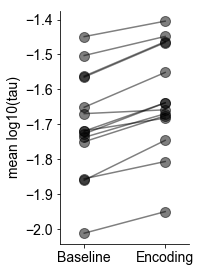

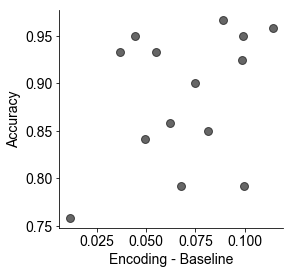

In [57]:
print('t-test on t-values: ',ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))
print('t-test on diff of means: ', ttest_1samp(df_patient['enc']-df_patient['pre'], 0))

plt.figure(figsize=(3,4))
plt.plot((df_patient['pre'],df_patient['enc']), 'ok-', alpha=0.5, ms=10)
despine()
plt.xticks([0,1], ['Baseline','Encoding']); 
#plt.yticks([-2, -1.5])
plt.ylabel('mean log10(tau)')
plt.xlim([-0.3,1.3])
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'pre_enc')
    
#x = df_patient['diff']
x = df_patient['enc'] - df_patient['pre']
y = df_patient['acc']
plt.figure(figsize=(4,4))
plt.plot(x,y, 'ok', alpha=0.6, ms=8)
plt.xlabel('Encoding - Baseline');plt.ylabel('Accuracy');
print('pearson:', pearsonr(x,y))
print('spearman: ', spearmanr(x,y,nan_policy='omit'))
despine()
if save_plot: plt.savefig(fig_path%'corr_tdiff_acc')

In [52]:
df_patient['data_qual'].values

array([60.42966043, 41.39626352, 43.52300242, 41.85897436, 26.24113475,
       46.5       , 25.55555556, 71.62878788, 42.95671313, 45.3968254 ,
       55.90277778, 64.12037037, 63.68055556, 68.56435644])

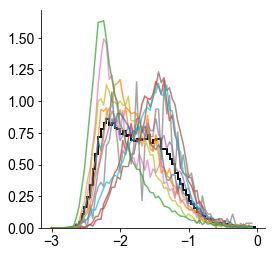

In [53]:
bins = np.arange(-3,0,0.04)
plt.figure(figsize=(4,4))
for i_p in patient_inds:
    counts = np.histogram(np.log10(df_alltrials[df_alltrials['patient']==i_p]['tau']), bins, density=True)[0]
    plt.plot(bins[:-1],counts, alpha=0.7)
    
#plt.legend(patient_inds)
plt.hist(np.log10(df_alltrials['tau']), bins, histtype='step', ec='k',lw=2, density=True);
despine();

### unpooled code

Ttest_1sampResult(statistic=8.399004691547507, pvalue=1.3072497955159234e-06)
                            OLS Regression Results                            
Dep. Variable:                    acc   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     6.427
Date:                Mon, 16 Dec 2019   Prob (F-statistic):             0.0142
Time:                        10:59:12   Log-Likelihood:                 23.242
No. Observations:                  14   AIC:                            -40.48
Df Residuals:                      11   BIC:                            -38.57
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater_equal
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/Users/rdgao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


,age,sex,acc_identity,acc_spatial,acc_temporal,rt_identity,rt_spatial,rt_temporal,sampling_rate,data_qual,pre,enc,diff,tvals,acc,rt
patient,,,,,,,,,,,,,,,,
s1,33.0,F,0.900,0.950,0.850,1947.968750,1844.540541,1556.852941,1000,63.063063,-1.758012,-1.691679,0.060415,2.638133,0.900000,1783.120744
s2,50.0,M,0.950,0.975,0.975,1155.111111,1092.236842,1169.378378,1000,44.641101,-1.743302,-1.654086,0.087766,4.281896,0.966667,1138.908777
s4,31.0,M,0.925,0.925,0.950,1562.411765,1740.277778,2069.567568,1000,43.523002,-1.510880,-1.449044,0.064161,3.751780,0.933333,1790.752370
s5,22.0,M,0.825,0.800,0.750,3174.531250,2535.322581,3142.178571,1000,42.532051,-1.655742,-1.558805,0.088339,4.312238,0.791667,2950.677467
s6,31.0,M,0.925,1.000,0.925,1685.702703,962.925000,1088.351351,1000,26.339638,-1.449716,-1.407750,0.073091,4.643240,0.950000,1245.659685
s7,34.0,M,0.900,1.000,0.975,779.371429,740.131579,647.594595,1000,48.863636,-1.884607,-1.770195,0.118837,6.647390,0.958333,722.365867
s8,27.0,M,0.900,0.975,0.975,1469.166667,1037.076923,989.282051,512,25.277778,-1.564917,-1.475482,0.116787,1.636406,0.950000,1165.175214
s9,34.0,F,0.875,0.825,0.825,1700.057143,1308.848485,1797.484848,512,76.590909,-1.875126,-1.823244,0.052748,3.939315,0.841667,1602.130159
s10,42.0,M,0.875,0.975,0.925,869.800000,661.297297,811.352941,1000,43.506970,-1.567784,-1.468318,0.107680,6.440870,0.925000,780.816746


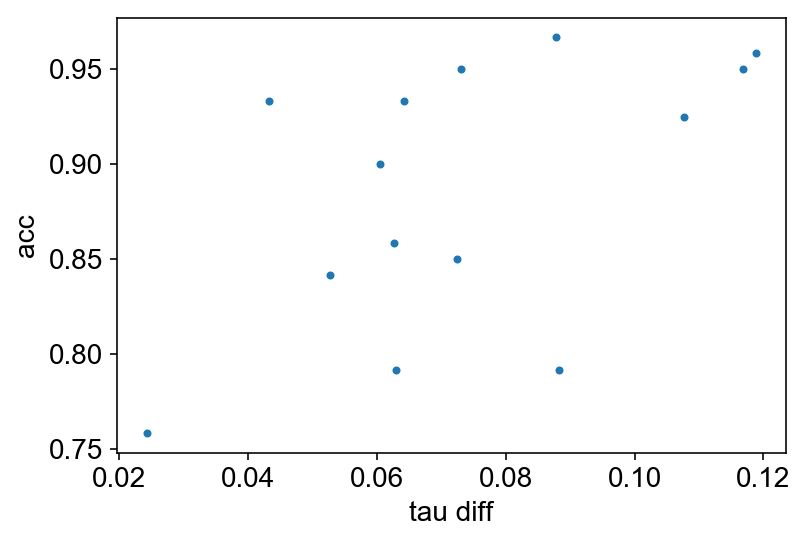

In [214]:
feature = all_tau
axis = 0 # 0 to mean across channels, 1 to mean across trials

grand_avg = []

for i_p in range(len(df_patient_info)):
    # remove bad fits if exp<0 or knee<0
    feature[i_p][(all_exp[i_p]<0) | (all_knee[i_p]<=0)] = np.nan
    #feature[i_p][(all_tau[i_p]<0)| (all_tau[i_p]>0.5)] = np.nan
    
    # get prestim, encoding, and difference per trial
    prestim = feature[i_p][0,:,:]
    encoding  = (feature[i_p][1,:,:]+feature[i_p][2,:,:])/2
    
    outliers = 4
    encoding = np.log10(encoding)
    z_encoding = np.abs((encoding - np.nanmean(encoding))/np.nanstd(encoding))
    encoding[z_encoding >= outliers] = np.nan
    prestim = np.log10(prestim)
    z_prestim = np.abs((prestim - np.nanmean(prestim))/np.nanstd(prestim))
    prestim[z_prestim >= outliers] = np.nan
    d_enc_pre = encoding - prestim
    
    mean_pre = np.nanmean(prestim,axis)
    mean_enc = np.nanmean(encoding,axis)
    mean_d = np.nanmean(d_enc_pre,axis)
    
    # t-test on mean difference
    tval, pv = ttest_1samp(mean_d, popmean=0, nan_policy='omit')
    
    # collect results
    grand_avg.append([(1-np.isnan(d_enc_pre).sum()/np.prod(d_enc_pre.shape))*100, 
                      np.nanmean(mean_pre), np.nanmean(mean_enc), np.nanmean(mean_d), tval])

df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index, columns=['data_qual', 'pre', 'enc', 'diff', 'tvals'])

valid_pat = df_patient_info.index[patient_inds].values 
df_patient = pd.concat((df_patient_info, df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)

df_patient = df_patient.loc[valid_pat]
print(ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))
mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())

plt.plot(df_patient['diff'],df_patient['acc'], '.')
plt.xlabel('tau diff');plt.ylabel('acc');
#plt.xlim([0, 0.01])
print(spearmanr(df_patient['diff'], df_patient['acc'], nan_policy='omit'))
#print(pearsonr(df_patient['diff'], df_patient['acc']))
df_patient

# Reproducing using Brad's fits

In [172]:
# load data
with open("../notebooks/Johnson/all_exp.txt", "rb") as fp: # unpickling
    all_exp = pickle.load(fp)
# with open("../notebooks/Johnson/all_offset.txt", "rb") as fp: # unpickling
#     all_offset = pickle.load(fp)
with open("../notebooks/Johnson/all_kfq.txt", "rb") as fp: # unpickling
    all_kfreq = pickle.load(fp)
with open("../notebooks/Johnson/all_tau.txt", "rb") as fp: # unpickling
    all_tau = pickle.load(fp)
    
feature = all_tau
axis = 0 # 0 to mean across channels, 1 to mean across trials

t_vals, p_vals = [], []
grand_avg = []
for i_p in range(len(df_patient_info)-1):    
    # get prestim, encoding, and difference per trial
    prestim = feature[i_p][0,:,:]
    encoding  = (feature[i_p][1,:,:]+feature[i_p][2,:,:])/2
    
    encoding[encoding <= 0] = np.nan
    prestim[prestim <= 0] = np.nan
    encoding[encoding > 0.5] = np.nan
    prestim[prestim > 0.5] = np.nan
    
    d_enc_pre = encoding - prestim
    
    mean_pre = np.nanmean(prestim,axis)
    mean_enc = np.nanmean(encoding,axis)
    mean_d = np.nanmean(d_enc_pre,axis)
    
    # t-test on mean difference
    tval, pv = ttest_1samp(mean_d, popmean=0, nan_policy='omit')
    grand_avg.append([np.nanmean(mean_pre), np.nanmean(mean_enc), np.nanmean(mean_d), tval])
    t_vals.append(tval)
    p_vals.append(pv)

#df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index, columns=['pre', 'enc', 'diff', 'tvals'])
df_result = pd.DataFrame(np.array(grand_avg), index=df_patient_info.index[[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16]], columns=['pre', 'enc', 'diff', 'tvals'])

valid_pat = df_patient_info.index[[0,1,3,4,5,6,7,8,9,10,11,12,13,15]].values # s3 has really bad data, s15 & s17 are same as s5 & s8
df_patient = pd.concat((df_patient_info, df_result), axis=1)
df_patient['acc'] = df_patient[['acc_identity','acc_spatial','acc_temporal']].mean(1)
df_patient['rt'] = df_patient[['rt_identity','rt_spatial','rt_temporal']].mean(1)
df_patient = df_patient.loc[valid_pat]
print(ttest_1samp(df_patient['tvals'], 0, nan_policy='omit'))

mod = smf.ols(formula='acc ~ age + diff', data=df_patient)
res = mod.fit()
print(res.summary())


FileNotFoundError: [Errno 2] No such file or directory: '../notebooks/Johnson/all_exp.txt'

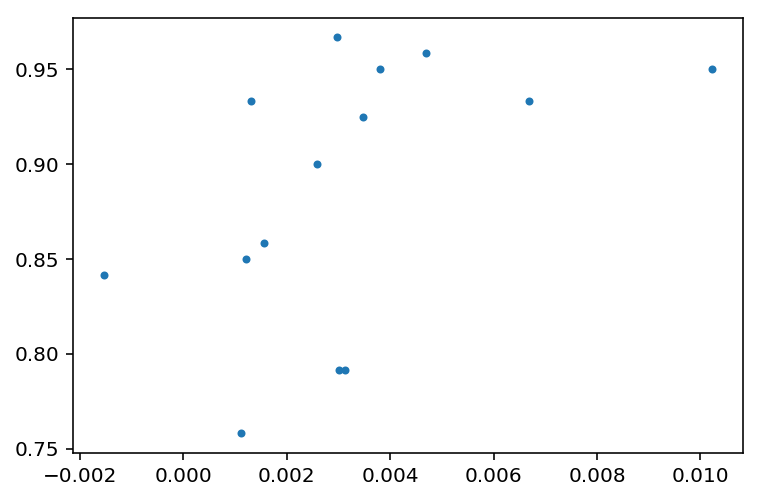

In [185]:
plt.plot(df_patient['diff'],df_patient['acc'], '.')

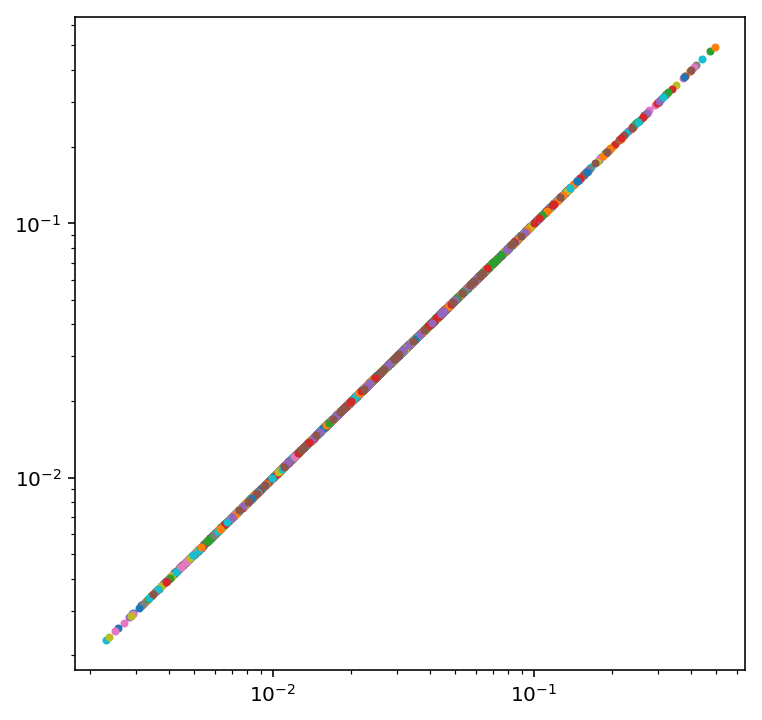

In [191]:
#bv_all_tau = all_tau
with open("../notebooks/Johnson/all_tau.txt", "rb") as fp: # unpickling
    bv_all_tau = pickle.load(fp)

plt.figure(figsize=(6,6))
cond=0
subj=-8
plt.plot(bv_all_tau[subj][cond], all_tau[subj][cond], '.');
#df_patient.index[-8]

In [194]:
all_tau

[array([[[       nan, 0.01062263, 0.01118819, ..., 0.00658618,
          0.00657521, 0.02446878],
         [0.00666273, 0.01892358, 0.00488353, ..., 0.04222276,
          0.00754101, 0.01624006],
         [0.00838021,        nan, 0.00544218, ..., 0.04481602,
          0.01007631, 0.01379476],
         ...,
         [0.01663331, 0.02048147, 0.00441489, ..., 0.00557668,
          0.00703279, 0.02290868],
         [0.01815044, 0.02212425, 0.03181135, ..., 0.02640274,
          0.07293245, 0.02491022],
         [0.02558703, 0.01543443, 0.00743301, ..., 0.02234141,
          0.01943496, 0.00851247]],
 
        [[0.00363532, 0.01110497, 0.01306794, ..., 2.18462338,
          0.00575535, 0.00500063],
         [0.05757515, 0.00605693,        nan, ..., 0.00905366,
          0.00574139, 0.01251635],
         [       nan, 0.01752722, 0.1540081 , ..., 0.03030747,
          0.03196186, 0.09033974],
         ...,
         [0.00412968, 0.00596408, 0.01314917, ..., 0.01559453,
                 nan, 0.

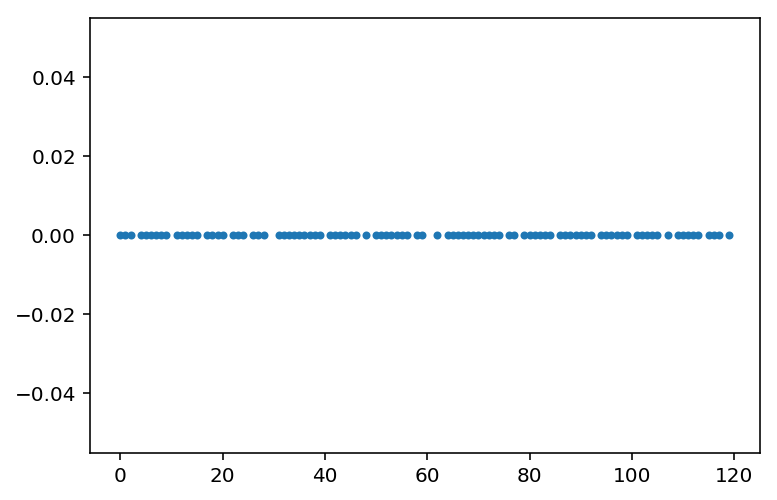

In [193]:
subj, cond, chan = -4, 1, 2
#plt.loglog(bv_all_tau[-2][cond,chan], all_tau[-2][cond,chan], '.')
#plt.plot(plt.xlim(),plt.ylim(), '--')
plt.plot(bv_all_tau[subj][cond,chan]-all_tau[subj][cond,chan], '.')